In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
from torchvision.datasets import ImageFolder 
import torch.optim.lr_scheduler as lr_scheduler
import torch.optim as optim
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import copy
from collections import OrderedDict 

In [17]:
# Check if CUDA is available
use_cuda = torch.cuda.is_available()
if not use_cuda:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [3]:
# Define transform and import dataset
transforms1 = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.CenterCrop((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transforms2 = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.CenterCrop((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    transforms.RandomHorizontalFlip(p=0.5)
])

full_dataset = ImageFolder('./data/raw/Taiwanese-Food-101', transform=transforms1)

# Define generator and set split size
generator1 = torch.Generator().manual_seed(38)
train_size = int(0.7 * len(full_dataset))
test_size = val_size = (len(full_dataset) - train_size)//2

# Split dataset to train, test, and validation
train_dataset, test_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size, val_size], generator = generator1)

train_dataset.dataset.transform = transforms2

"""
train_dataset = torch.load('../data/processed/Taiwanese-Food-101/train/train_dataset.pt')
val_dataset = torch.load("../data/processed/Taiwanese-Food-101/val/val_dataset.pt")
test_dataset = torch.load("../data/processed/Taiwanese-Food-101/test/test_dataset.pt")
"""

In [19]:
# Define hypterparameters
batch_size = 64

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

class_names = class_names = test_dataset.dataset.classes

In [20]:
model = models.densenet161(weights = "DEFAULT")

# Freeze the parameters of the pre-trained model to avoid updating them during training
for param in model.parameters():
    param.requires_grad = False
    

for param in list(model.features.denseblock4.parameters()) + list(model.features.denseblock3.parameters()):
    param.requires_grad = True

# Replace the classifier with your custom classifier
model.classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(2208, 500)),  # Adjusted input size to match DenseNet-161 output
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(500, 101)),  # Adjusted output size to match the number of classes (101 in this case)
                          ('output', nn.LogSoftmax(dim=1))
                          ]))

In [21]:
def train_model(model, criterion, optimizer, train_loader, valid_loader, n_epochs, mininterval, patience):
    train_losses = []
    valid_losses = []
    train_accuracies = []
    valid_accuracies = []
    no_improvement_count = 0
    best_model = None
    best_val_loss = float('inf')
    
    for epoch in range(1, n_epochs+1):
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        
        for batch_idx, (data, target) in enumerate(tqdm(train_loader, desc=f'Epoch {epoch} Training', mininterval = mininterval)):
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = output.max(1)
            train_total += target.size(0)
            train_correct += predicted.eq(target).sum().item()
            
            if batch_idx % 150 == 0:
                print(f'Batch {batch_idx}, Loss: {loss.item():.4f}, Acc: {100 * train_correct/train_total:.2f}%')
        
        train_loss = train_loss / len(train_loader)
        train_accuracy = 100 * train_correct / train_total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        
        model.eval()
        valid_loss = 0.0
        valid_correct = 0
        valid_total = 0
        
        with torch.no_grad():
            for data, target in tqdm(valid_loader, desc=f'Epoch {epoch} Validation', mininterval=mininterval):
                if use_cuda:
                    data, target = data.cuda(), target.cuda()
                
                output = model(data)
                loss = criterion(output, target)
                valid_loss += loss.item()
                
                _, predicted = output.max(1)
                valid_total += target.size(0)
                valid_correct += predicted.eq(target).sum().item()
        
        valid_loss = valid_loss / len(valid_loader)
        valid_accuracy = 100 * valid_correct / valid_total
        valid_losses.append(valid_loss)
        valid_accuracies.append(valid_accuracy)
        
        print(f'Epoch {epoch}')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%')
        print(f'Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_accuracy:.2f}%')
        
        scheduler.step(valid_loss)
        
        # Early Stopping
        if valid_loss < best_val_loss:
            best_val_loss = valid_loss
            best_model = copy.deepcopy(model)
            patience_count = 0  # Reset counter if validation loss improves
        else:
            patience_count += 1  # Increment counter if no improvement

        if patience_count >= patience:
            print(f"Early stopping at epoch {epoch}. No improvement in validation loss for {patience} epochs.")
            model = best_model  # Load the best model
            break
        
    return model, train_losses, valid_losses, train_accuracies, valid_accuracies

In [22]:
n_epochs = 30
patience = 4
mininterval = 5
LR = 0.0001

criterion = nn.CrossEntropyLoss()
optimizer1 = optim.Adam(model.parameters(), lr=LR)
optimizer2 = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-5)
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001, betas=[0.9, 0.999])
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer2, mode='min', factor=0.1, patience=1, verbose=True)

In [ ]:
if use_cuda:
    model.cuda()

model, train_losses, valid_losses, train_accuracies, valid_accuracies = train_model(
    model=model,
    criterion=criterion,
    optimizer=optimizer2,
    train_loader=train_loader,
    valid_loader=valid_loader,
    n_epochs=n_epochs,
    mininterval=mininterval,
    patience=patience
)

Epoch 1 Training:   0%|          | 0/221 [00:00<?, ?it/s]

Batch 0, Loss: 4.5982, Acc: 1.56%
Batch 150, Loss: 1.6992, Acc: 41.23%


Epoch 1 Validation:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 1
Train Loss: 2.5618, Train Acc: 51.55%
Valid Loss: 0.8897, Valid Acc: 80.69%


Epoch 2 Training:   0%|          | 0/221 [00:00<?, ?it/s]

Batch 0, Loss: 0.9852, Acc: 79.69%
Batch 150, Loss: 0.6016, Acc: 86.23%


Epoch 2 Validation:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 2
Train Loss: 0.5937, Train Acc: 86.82%
Valid Loss: 0.4922, Valid Acc: 87.66%


Epoch 3 Training:   0%|          | 0/221 [00:00<?, ?it/s]

Batch 0, Loss: 0.2522, Acc: 98.44%
Batch 150, Loss: 0.1241, Acc: 95.37%


Epoch 3 Validation:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 3
Train Loss: 0.2258, Train Acc: 95.10%
Valid Loss: 0.3821, Valid Acc: 89.41%


Epoch 4 Training:   0%|          | 0/221 [00:00<?, ?it/s]

Batch 0, Loss: 0.1386, Acc: 96.88%
Batch 150, Loss: 0.0588, Acc: 98.22%


Epoch 4 Validation:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 4
Train Loss: 0.0981, Train Acc: 98.04%
Valid Loss: 0.3724, Valid Acc: 89.54%


Epoch 5 Training:   0%|          | 0/221 [00:00<?, ?it/s]

Batch 0, Loss: 0.0496, Acc: 100.00%
Batch 150, Loss: 0.0263, Acc: 99.05%


Epoch 5 Validation:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 5
Train Loss: 0.0554, Train Acc: 98.99%
Valid Loss: 0.3404, Valid Acc: 90.66%


Epoch 6 Training:   0%|          | 0/221 [00:00<?, ?it/s]

Batch 0, Loss: 0.0726, Acc: 96.88%
Batch 150, Loss: 0.0181, Acc: 99.46%


Epoch 6 Validation:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 6
Train Loss: 0.0344, Train Acc: 99.43%
Valid Loss: 0.3351, Valid Acc: 90.76%


Epoch 7 Training:   0%|          | 0/221 [00:00<?, ?it/s]

Batch 0, Loss: 0.0118, Acc: 100.00%
Batch 150, Loss: 0.0193, Acc: 99.72%


Epoch 7 Validation:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 7
Train Loss: 0.0215, Train Acc: 99.70%
Valid Loss: 0.3351, Valid Acc: 90.83%


Epoch 8 Training:   0%|          | 0/221 [00:00<?, ?it/s]

Batch 0, Loss: 0.0145, Acc: 100.00%
Batch 150, Loss: 0.0471, Acc: 99.71%


Epoch 8 Validation:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 8
Train Loss: 0.0204, Train Acc: 99.65%
Valid Loss: 0.3790, Valid Acc: 90.03%
Epoch 00008: reducing learning rate of group 0 to 1.0000e-05.


Epoch 9 Training:   0%|          | 0/221 [00:00<?, ?it/s]

Batch 0, Loss: 0.0116, Acc: 100.00%
Batch 150, Loss: 0.0041, Acc: 99.74%


Epoch 9 Validation:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 9
Train Loss: 0.0138, Train Acc: 99.82%
Valid Loss: 0.3171, Valid Acc: 91.52%


Epoch 10 Training:   0%|          | 0/221 [00:00<?, ?it/s]

Batch 0, Loss: 0.0040, Acc: 100.00%
Batch 150, Loss: 0.0143, Acc: 99.95%


Epoch 10 Validation:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 10
Train Loss: 0.0084, Train Acc: 99.94%
Valid Loss: 0.3130, Valid Acc: 91.52%


Epoch 11 Training:   0%|          | 0/221 [00:00<?, ?it/s]

Batch 0, Loss: 0.0034, Acc: 100.00%
Batch 150, Loss: 0.0048, Acc: 99.96%


Epoch 11 Validation:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 11
Train Loss: 0.0069, Train Acc: 99.96%
Valid Loss: 0.3142, Valid Acc: 91.65%


Epoch 12 Training:   0%|          | 0/221 [00:00<?, ?it/s]

Batch 0, Loss: 0.0058, Acc: 100.00%
Batch 150, Loss: 0.0094, Acc: 99.95%


Epoch 12 Validation:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 12
Train Loss: 0.0055, Train Acc: 99.96%
Valid Loss: 0.3121, Valid Acc: 91.75%


Epoch 13 Training:   0%|          | 0/221 [00:00<?, ?it/s]

Batch 0, Loss: 0.0027, Acc: 100.00%
Batch 150, Loss: 0.0096, Acc: 99.99%


Epoch 13 Validation:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 13
Train Loss: 0.0049, Train Acc: 99.99%
Valid Loss: 0.3018, Valid Acc: 91.82%


Epoch 14 Training:   0%|          | 0/221 [00:00<?, ?it/s]

Batch 0, Loss: 0.0053, Acc: 100.00%
Batch 150, Loss: 0.0028, Acc: 99.99%


Epoch 14 Validation:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 14
Train Loss: 0.0044, Train Acc: 99.99%
Valid Loss: 0.3074, Valid Acc: 91.91%


Epoch 15 Training:   0%|          | 0/221 [00:00<?, ?it/s]

Batch 0, Loss: 0.0026, Acc: 100.00%
Batch 150, Loss: 0.0019, Acc: 100.00%


Epoch 15 Validation:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 15
Train Loss: 0.0039, Train Acc: 100.00%
Valid Loss: 0.3047, Valid Acc: 92.05%
Epoch 00015: reducing learning rate of group 0 to 1.0000e-06.


Epoch 16 Training:   0%|          | 0/221 [00:00<?, ?it/s]

Batch 0, Loss: 0.0026, Acc: 100.00%
Batch 150, Loss: 0.0019, Acc: 99.97%


Epoch 16 Validation:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 16
Train Loss: 0.0043, Train Acc: 99.97%
Valid Loss: 0.3043, Valid Acc: 92.05%


Epoch 17 Training:   0%|          | 0/221 [00:00<?, ?it/s]

Batch 0, Loss: 0.0026, Acc: 100.00%
Batch 150, Loss: 0.0031, Acc: 99.94%


Epoch 17 Validation:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 17
Train Loss: 0.0040, Train Acc: 99.96%
Valid Loss: 0.3047, Valid Acc: 91.85%
Epoch 00017: reducing learning rate of group 0 to 1.0000e-07.
Early stopping at epoch 17. No improvement in validation loss for 4 epochs.


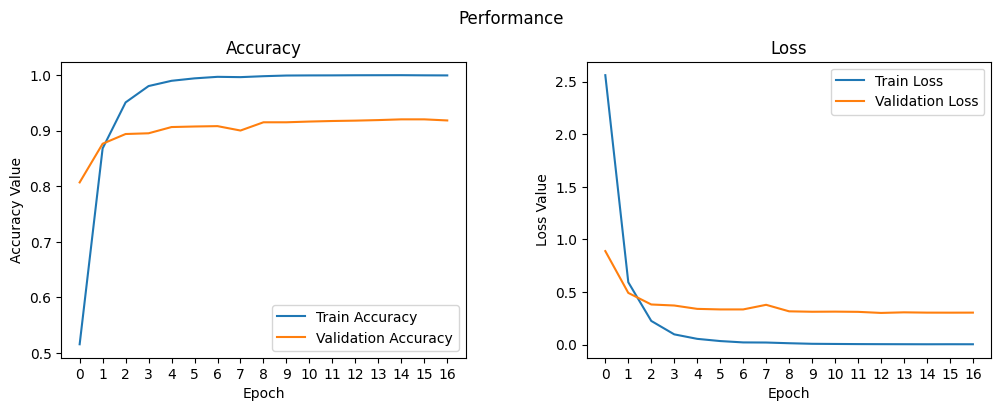

In [24]:
# Ploting accuracy and loss
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

train_acc = []
val_acc = []
 
for i in range(len(train_accuracies)):
    train_acc.append(train_accuracies[i] * 0.01)
    val_acc.append(valid_accuracies[i] * 0.01)

    
epoch_list = list(range(0, len(train_accuracies)))
ax1.plot(epoch_list, train_acc, label='Train Accuracy')
ax1.plot(epoch_list, val_acc, label='Validation Accuracy')
ax1.set_xticks(np.arange(0, len(epoch_list)))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")
    
ax2.plot(epoch_list, train_losses, label='Train Loss')
ax2.plot(epoch_list, valid_losses, label='Validation Loss')
ax2.set_xticks(np.arange(0, len(epoch_list)))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [ ]:
# torch.save(model.state_dict(), 'densenet161_unfreeze2_sch')